# Extract "Item 7. Management's Discussion and Analysis..." (MD&A) from 10-K files.

Notes:
- Finds Item 7 start using tolerant regex variants (handles OCR/HTML artifacts like "Management s" or “Management’s”).
- Stops at the first boundary: Item 7A or Item 8 (tolerant to variants).
- Writes UTF-8 output files, logs a summary table at the end.

In [18]:
# --- Robust Item 7 (MD&A) extractor for messy 10-Ks (notebook cell) ---

import re
from pathlib import Path

# 1) Normalization
def normalize_text(t: str) -> str:
    reps = {
        "\u00a0": " ",  # nbsp
        "\u2018": "'", "\u2019": "'", "\u201B": "'",
        "\u201C": '"', "\u201D": '"',
        "\u2212": "-", "\u2013": "-", "\u2014": "-",
    }
    for k, v in reps.items():
        t = t.replace(k, v)
    # turn common block tags into newlines (helps ^ anchors), collapse tabs/spaces
    t = re.sub(r"(?i)</?(p|div|br|tr|li|h[1-6])[^>]*>", "\n", t)
    t = re.sub(r"[ \t]+", " ", t)
    t = re.sub(r"\n{3,}", "\n\n", t)
    return t

def read_file(path: Path) -> str:
    data = path.read_bytes()
    try:
        return data.decode("utf-8", errors="ignore")
    except Exception:
        return data.decode("latin-1", errors="ignore")

# 2) Patterns
ITEM   = r"ITEM\s*"
NUM7   = r"7\s*[\.\)]?\s*"

# Full title variants (very tolerant)
MDNA = (
    r"MANAGEMENT\s*['’]?\s*S?\s*DISCUSSION\s*AND\s*ANALYSIS\s*OF\s*"
    r"FINANCIAL\s*CONDITION\s*AND\s*RESULTS\s*OF\s*OPERATIONS"
)

START_PATTERNS = [
    # Canonical header line
    re.compile(rf"^[ \t]*{ITEM}{NUM7}{MDNA}.*?$", flags=re.I | re.M),
    # Broken/HTMLy title spread across text
    re.compile(rf"{ITEM}{NUM7}.*?{MDNA}", flags=re.I | re.S),
    # Fallback: a clean "Item 7" header line (when the long title is missing)
    re.compile(r"^[ \t]*ITEM\s*7\s*[\.\)]?\s*$", flags=re.I | re.M),
]

# End boundaries (the earliest one wins)
END_BOUNDARY = re.compile(
    "|".join([
        rf"^[ \t]*{ITEM}7\s*A\s*[\.\)]?.*$",     # Item 7A
        rf"^[ \t]*{ITEM}8\s*[\.\)]?.*$",         # Item 8
        r"^[ \t]*PART\s+III\b.*$",               # PART III (some filers jump straight here)
        r"^[ \t]*SIGNATURES\b.*$",               # Signatures (very conservative stop)
        r"^[ \t]*INDEX\s+TO\s+CONSOLIDATED\s+FINANCIAL\s+STATEMENTS\b.*$",
    ]),
    flags=re.I | re.M
)

# Simple “looks like TOC” detector to reject spurious starts
TOC_LINE = re.compile(r"^.*?\.{2,}\s*\d+\s*$")  # dotted leader + page number
NEAR_TOC  = re.compile(r"TABLE\s+OF\s+CONTENTS", flags=re.I)

def _build_span(text: str, start_idx: int):
    """Return (chunk, end_idx) from start_idx to the nearest boundary; None if too tiny."""
    tail = text[start_idx:]
    m_end = END_BOUNDARY.search(tail)
    end_idx = start_idx + (m_end.start() if m_end else len(text))
    chunk = text[start_idx:end_idx].strip()
    return chunk, end_idx

def _likely_toc_region(text: str, start_idx: int, lookback: int = 2500, lookahead: int = 300):
    """Heuristic: around start, do we see TOC markers / dotted leaders?"""
    left = max(0, start_idx - lookback)
    right = min(len(text), start_idx + lookahead)
    window = text[left:right]
    # dotted leader line near the start OR explicit 'TABLE OF CONTENTS' nearby
    first_line = text[start_idx:text.find("\n", start_idx) if "\n" in text[start_idx:] else start_idx+200]
    return bool(TOC_LINE.search(first_line)) or bool(NEAR_TOC.search(window))

def find_item7_block(doc_text: str, min_len: int = 1500) -> str | None:
    """
    Return the best Item 7 (MD&A) block.
    Strategy:
      * Gather all candidate start indices from tolerant patterns.
      * For each start, build [start, next boundary).
      * Skip spans that look like TOC (or are too short).
      * Prefer the first span meeting min_len; otherwise return the longest non-TOC span.
    """
    # Collect candidate starts (dedup + sort)
    starts = []
    for pat in START_PATTERNS:
        for m in pat.finditer(doc_text):
            starts.append(m.start())
    starts = sorted(set(starts))
    if not starts:
        return None

    best_span = ""
    for s in starts:
        chunk, _ = _build_span(doc_text, s)
        if not chunk or len(chunk) < 400:  # basic sanity check
            continue
        # Skip obvious TOC-y starts
        if _likely_toc_region(doc_text, s):
            continue
        # Quality hint: early presence of key phrases in the first 1.5k chars
        head = chunk[:1500].upper()
        score_hit = ("RESULTS OF OPERATIONS" in head) or ("FINANCIAL CONDITION" in head)
        if len(chunk) >= min_len and score_hit:
            return chunk  # good enough — return immediately
        # track the longest reasonable candidate as fallback
        if len(chunk) > len(best_span):
            best_span = chunk

    # If nothing passed the quality checks, return the longest acceptable span (if any)
    if best_span and len(best_span) >= 800:  # relaxed floor for tricky filers
        return best_span
    return None


In [32]:
# 2) Patterns
NUM1    = r"1\s*[\.\)\-:–—]?\s*"

# Full title variants (very tolerant)
BUSINESS_TITLE = r"BUSINESS(?:\s+OVERVIEW|\s+AND\s+OVERVIEW)?"

START_PATTERNS_ITEM1 = [
    # Canonical one-line header: "Item 1. Business"
    re.compile(rf"^[ \t]*{ITEM}{NUM1}{BUSINESS_TITLE}.*?$", flags=re.I | re.M),
    # Messy/HTMLy: allow stuff between "Item 1" and the (business) title
    re.compile(rf"{ITEM}{NUM1}.*?{BUSINESS_TITLE}", flags=re.I | re.S),
    # Fallback: bare "Item 1" header line (when the word BUSINESS is on next line)
    re.compile(r"^[ \t]*ITEM\s*1\s*[\.\)\-:–—]?\s*$", flags=re.I | re.M),
]

# End boundaries — earliest hit wins
END_BOUNDARY_ITEM1 = re.compile(
    "|".join([
        rf"^[ \t]*{ITEM}1\s*A\s*[\.\)\-:–—]?\s*.*$",   # Item 1A. Risk Factors
        rf"^[ \t]*{ITEM}1\s*B\s*[\.\)\-:–—]?\s*.*$",   # Item 1B. Unresolved Staff Comments
        rf"^[ \t]*{ITEM}2\s*[\.\)\-:–—]?\s*.*$",       # Item 2. Properties
        r"^[ \t]*PART\s+II\b.*$",                      # Part II (hard stop if it jumps)
        r"^[ \t]*SIGNATURES\b.*$",                     # Signatures (very conservative stop)
        r"^[ \t]*INDEX\s+TO\s+CONSOLIDATED\s+FINANCIAL\s+STATEMENTS\b.*$",
    ]),
    flags=re.I | re.M
)

PART_I   = re.compile(r"^[ \t]*PART\s+I\b.*$", flags=re.I | re.M)

def _build_span_item1(text: str, start_idx: int):
    """Return (chunk, end_idx) from start_idx to the nearest boundary; None if too tiny."""
    tail = text[start_idx:]
    m_end = END_BOUNDARY_ITEM1.search(tail)
    end_idx = start_idx + (m_end.start() if m_end else len(text))
    chunk = text[start_idx:end_idx].strip()
    return chunk, end_idx

def _likely_toc_region_item1(text: str, start_idx: int, lookback: int = 2500, lookahead: int = 300):
    """Heuristic: around start, do we see TOC markers / dotted leaders?"""
    left = max(0, start_idx - lookback)
    right = min(len(text), start_idx + lookahead)
    window = text[left:right]
    # dotted leader line near the start OR explicit 'TABLE OF CONTENTS' nearby
    first_line = text[start_idx:text.find("\n", start_idx) if "\n" in text[start_idx:] else start_idx+200]
    return bool(TOC_LINE.search(first_line)) or bool(NEAR_TOC.search(window))

def find_item1_block(doc_text: str, min_len: int = 1500) -> str | None:
    """
    Return the best Item 1 (Business) block.
    Strategy:
      * Gather all candidate start indices from tolerant patterns.
      * For each start, build [start, next boundary).
      * Skip spans that look like TOC (or are too short).
      * Prefer the first span meeting min_len; otherwise return the longest non-TOC span.
    """
    # Collect candidate starts (dedup + sort)
    starts = []
    for pat in START_PATTERNS_ITEM1:
        for m in pat.finditer(doc_text):
            starts.append(m.start())
    starts = sorted(set(starts))
    if not starts:
        return None

    best_span = ""
    for s in starts:
        chunk, _ = _build_span_item1(doc_text, s)
        if not chunk or len(chunk) < 400:  # basic sanity check
            continue
        # Skip obvious TOC-y starts
        if _likely_toc_region_item1(doc_text, s):
            continue
        # Quality hint: early presence of key phrases in the first 1.5k chars
        head = chunk[:1500].upper()
        score_hit = ("RESULTS OF OPERATIONS" in head) or ("FINANCIAL CONDITION" in head)
        if len(chunk) >= min_len and score_hit:
            return chunk  # good enough — return immediately
        # track the longest reasonable candidate as fallback
        if len(chunk) > len(best_span):
            best_span = chunk

    # If nothing passed the quality checks, return the longest acceptable span (if any)
    if best_span and len(best_span) >= 800:  # relaxed floor for tricky filers
        return best_span
    return None

In [33]:
import os
import pandas as pd

sample_data_path = r".\data\l6\sample10k"

item17_df = pd.DataFrame(columns=["filename", "cik", "item7_text", 'item1_text   '])
for p in sorted(os.listdir(sample_data_path)):
    file_info = p.split('.')[0].split("_")
    cik = file_info[-2]
    file_name = file_info[-1]

    p = Path(sample_data_path) / p

    raw = read_file(p)
    text = normalize_text(raw)

    # Optionally strip HTML tags for matching; keep a copy for output
    # We run matching on a "lightly de-tagged" version to be robust.
    detag = re.sub(r"(?is)<[^>]+>", " ", text)
    detag = normalize_text(detag)

    item7 = find_item7_block(detag)
    if item7:
        item17_df.loc[item17_df.shape[0]] = pd.Series({"filename": file_name, "cik": cik, "item7_text": item7}, name=item7_df.shape[0])
    else:
        print(f"[MISS] {p.name}  (Item 7 not found with current patterns)")
        # p.unlink()  # delete the file if Item 7 not found

    item1 = find_item1_block(text)
    if item1:
        item17_df.loc[item17_df.shape[0]-1, 'item1_text'] = item1
    else:
        print(f"[MISS] {p.name}  (Item 1 not found with current patterns)")
        # p.unlink()  # delete the file if Item 1 not found

print(f"Extracted Item 1 and 7 from {item17_df.shape[0]} files.")

Extracted Item 1 and 7 from 205 files.


In [34]:
import nltk
from nltk.corpus import stopwords
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup


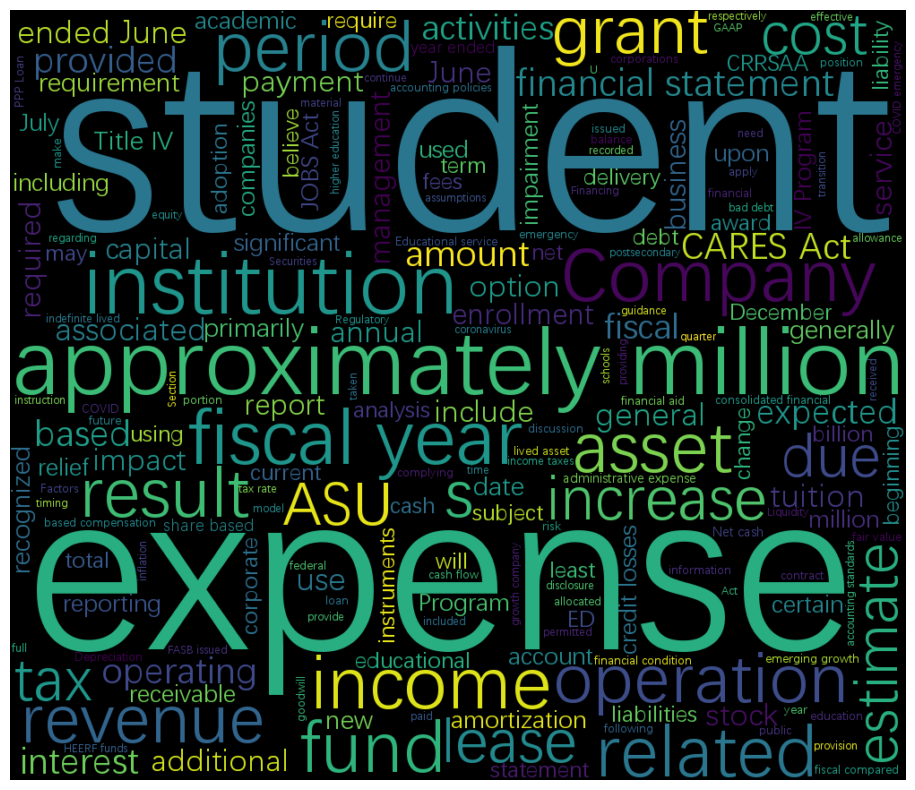

In [37]:
# Segment text content
token = nltk.word_tokenize(item17_df.loc[0, 'item7_text'])

page_text = ' '.join(token)
wordcloud = WordCloud(font_path="Deng.ttf", width=1000, height=860, ).generate(page_text)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

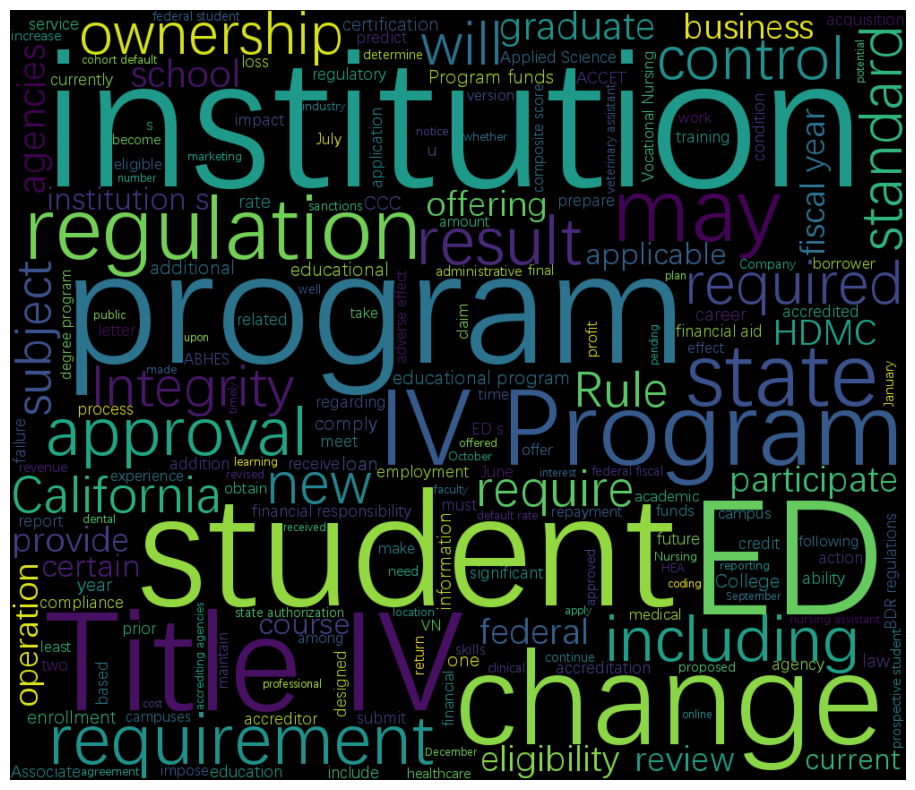

In [38]:
# Segment text content
token = nltk.word_tokenize(item17_df.loc[0, 'item1_text'])

page_text = ' '.join(token)
wordcloud = WordCloud(font_path="Deng.ttf", width=1000, height=860, ).generate(page_text)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [39]:
item17_df.loc[0]

filename                                      0001493152-24-038926
cik                                                        1836754
item7_text       ITEM\r\n7. MANAGEMENT S DISCUSSION AND ANALYSI...
item1_text                                                     NaN
item1_text       ITEM\r\n1. BUSINESS \r\n\r\nOverview \r\n\r\nW...
Name: 0, dtype: object